In [1]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Data Preprocessing
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

import os
import numpy as np
from scipy.signal import resample

def load_data(folder_path):
    data_dict = {}
    labels = None

    for file in sorted(os.listdir(folder_path)):
        if file.endswith('.npy'):
            file_path = os.path.join(folder_path, file)
            data = np.load(file_path)

            if 'label' in file.lower():
                labels = data.squeeze()
            elif data.ndim == 3:
                sensor_name = file.replace('.npy', '')
                data_dict[sensor_name] = data

    return data_dict, labels

def normalize_data(data_dict):
    normalized_data = {}
    for sensor, data in data_dict.items():
        mean = data.mean(axis=(0, 1), keepdims=True)
        std = data.std(axis=(0, 1), keepdims=True) + 1e-8
        normalized_data[sensor] = (data - mean) / std
    return normalized_data

In [2]:
!pip install tsfresh

In [3]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Feature-Extraction
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from tsfresh.feature_extraction.feature_calculators import mean_abs_change, cid_ce

def zero_crossing_rate(signal):
    return ((signal[:-1] * signal[1:]) < 0).sum()

def extract_features_from_sample(sample):
    """
    sample: ndarray with shape (T, C)
    Returns: feature vector (flattened over all channels)
    """

    T, C = sample.shape
    features = []

    for c in range(C):
        sig = sample[:, c]

        iqr = np.percentile(sig, 75) - np.percentile(sig, 25)
        pos_peaks, _ = find_peaks(sig)
        neg_peaks, _ = find_peaks(-sig)
        num_pos_peaks = len(pos_peaks)
        num_neg_peaks = len(neg_peaks)
        mac = mean_abs_change(sig)
        cid = cid_ce(sig, normalize=True)


        features.extend([
            np.max(sig),               # Maximum
            np.min(sig),               # Minimum
            np.mean(sig),              # Average
            np.std(sig),               # Standard-deviation
            zero_crossing_rate(sig),   # Zero Crossing Rate
            np.percentile(sig, 20),    # Percentil 20
            np.percentile(sig, 50),    # Median (Percentil 50)
            np.percentile(sig, 80),    # Percentil 80
            iqr,                       # Interquartile(IQR)
            np.var(sig),               # Variance
            num_pos_peaks,             # Number positive Peaks
            num_neg_peaks,             # Number negative Peaks
            mac,                       # Mean Absolute Change
            cid                        # Complexity invariant distance
        ])
    return np.array(features)

def extract_features_from_sample_combined(sample_dict):
    """
    sample_dict: dict of sensor_name -> ndarray (T, C)
    Returns: combined feature vector (flattened over all channels and sensors)
    """
    features = []

    for sensor_name, sample in sample_dict.items():
        feats = extract_features_from_sample(sample)  # Extract features for each sensor sample
        features.extend(feats)  # Combine features from all sensors into a single vector

    return np.array(features)

def extract_features(data_dict):
    """
    data_dict: dict of sensor_name -> ndarray (N, T, C)
    Returns: X -> ndarray (N, F) - Features
    """
    feature_list = []
    n_samples = None

    for sensor_name, sensor_data in data_dict.items():
        if n_samples is None:
            n_samples = sensor_data.shape[0]
        elif n_samples != sensor_data.shape[0]:
            raise ValueError(f"Inkonsistente Anzahl an Samples im Sensor '{sensor_name}'")

    # Extract features for each sample by combining all sensors
    for i in range(n_samples):
        sample_dict = {sensor_name: data[i] for sensor_name, data in data_dict.items()}
        feats = extract_features_from_sample_combined(sample_dict)
        feature_list.append(feats)

     # Stack all features
    X = np.vstack(feature_list)
    return X

In [4]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Feature-Selection: RFE with Cross-Validation
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

import numpy as np
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

def run_feature_selection_rfecv(X, y, cv_folds=5, scoring='f1_macro'):
    print(f"[INFO] Starte Feature Selection - Input Shape: {X.shape}")

    print("[INFO] Skaliere Features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("[INFO] Features skaliert.")

    print("[INFO] Initialisiere XGBoostClassifier...")
    estimator = XGBClassifier(n_estimators=100, random_state=42, tree_method='hist', device='cuda', verbosity=1, n_jobs=1)

    print("[INFO] Initialisiere StratifiedKFold...")
    cv = StratifiedKFold(n_splits=cv_folds)

    print("[INFO] Initialisiere RFECV...")
    selector = RFECV(estimator=estimator, step=1, cv=cv, scoring=scoring, n_jobs=1, verbose=1)

    print("[INFO] Starte RFECV.fit...")
    selector.fit(X_scaled, y)
    print("[INFO] RFECV abgeschlossen.")

    X_selected = selector.transform(X_scaled)
    selected_indices = np.where(selector.support_)[0]

    print(f"[INFO] Optimal number of features: {selector.n_features_}")
    print("[INFO] Top Feature Indices:", selected_indices)

    return X_selected, scaler, selector

In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
DO NOT RUN!
Main: Load Data, extract Features, save Feature-Selection Parameters, train Classifier
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import joblib

from google.colab import drive
drive.mount('/content/drive')

# === Set the path to the training and test folders ===
training_folder = "/content/drive/MyDrive/SS25/MDS4AT/02_ActivityMonitoring/training"
testing_folder = "/content/drive/MyDrive/SS25/MDS4AT/02_ActivityMonitoring/testing"

# === Load Trainings- und Testdata ===
training_data_dict, training_labels = load_data(training_folder)
testing_data_dict, testing_labels = load_data(testing_folder)

# === Normalize Trainings- und Testdata ===
normalized_training_data = normalize_data(training_data_dict)
normalized_testing_data = normalize_data(testing_data_dict)

# === Feature-Extraktion ===
X_train = extract_features(normalized_training_data)
X_test = extract_features(normalized_testing_data)

# === Feature Selection ===
X_train_selected, scaler, selector = run_feature_selection_rfecv(X_train, training_labels)

# === Save Scaler & Selector ===
joblib.dump(scaler, "/content/drive/MyDrive/SS25/MDS4AT/02_ActivityMonitoring/models/scaler_XGB.pkl")
joblib.dump(selector, "/content/drive/MyDrive/SS25/MDS4AT/02_ActivityMonitoring/models/rfecv_selector_XGB.pkl")

# === Transform Testdata ===
X_test_scaled = scaler.transform(X_test)
X_test_selected = selector.transform(X_test_scaled)

# === Split Training / Validation ===
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_selected, training_labels, test_size=0.2, random_state=42)

# === Classification ===
clf = XGBClassifier(n_estimators=100, random_state=42, tree_method='hist', device='cuda')

# === Train model on Trainingsdata ===
clf.fit(X_train_split, y_train_split)

# === Validation ===
y_val_pred = clf.predict(X_val_split)

# === Test ===
y_test_pred = clf.predict(X_test_selected)

# === Output when executing this cell ===

# [INFO] Starte Feature Selection - Input Shape: (2284, 378)
# [INFO] Skaliere Features...
# [INFO] Features skaliert.
# [INFO] Initialisiere XGBoostClassifier...
# [INFO] Initialisiere StratifiedKFold...
# [INFO] Initialisiere RFECV...
# [INFO] Starte RFECV.fit...
# ...
# [INFO] RFECV abgeschlossen.
# [INFO] Optimal number of features: 156
# [INFO] Top Feature Indices: [  0   1   5  13  14  15  16  19  20  21  22  27  28  29  30  33  35  38
#  40  41  42  47  54  56  57  58  59  63  64  68  69  73  75  77  79  85
#  86  87  88  89  91  92  95  98 102 103 105 106 115 119 122 123 128 129
# 140 141 142 143 145 147 152 153 155 156 161 162 163 164 175 178 182 183
# 184 185 187 188 189 190 194 196 197 199 201 202 208 212 213 215 216 218
# 220 224 225 228 229 230 231 241 245 246 247 252 253 254 257 258 259 261
# 263 264 266 267 268 271 272 273 274 278 280 281 282 284 285 291 292 293
# 297 301 302 305 306 307 310 311 313 320 322 324 330 334 335 336 337 339
# 340 343 350 351 352 354 355 356 363 364 365 371]

Output hidden; open in https://colab.research.google.com to view.

In [5]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
SUPERVISOR ADJUSTMENT NEEDED; SEE COMMENTS
Main: Load Data, extract Features, use Feature-Selection Parameters, train Classifier
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import joblib

from google.colab import drive
drive.mount('/content/drive')

# === Set the path to the training and test folders; PLEASE ADJUST it to run the code locally on your machine. ===
training_folder = "/content/drive/MyDrive/SS25/MDS4AT/02_ActivityMonitoring/training"
testing_folder = "/content/drive/MyDrive/SS25/MDS4AT/02_ActivityMonitoring/testing"

# === Load Trainings- und Testdata ===
training_data_dict, training_labels = load_data(training_folder)
testing_data_dict, testing_labels = load_data(testing_folder)

# === Normalize Trainings- und Testdata ===
normalized_training_data = normalize_data(training_data_dict)
normalized_testing_data = normalize_data(testing_data_dict)

# === Feature-Extraktion ===
X_train = extract_features(normalized_training_data)
X_test = extract_features(normalized_testing_data)

# === Load Scaler & Selector; PLEASE ADJUST it to run the code locally on your machine. ===
scaler = joblib.load("/content/drive/MyDrive/SS25/MDS4AT/02_ActivityMonitoring/models/scaler_XGB.pkl")
selector = joblib.load("/content/drive/MyDrive/SS25/MDS4AT/02_ActivityMonitoring/models/rfecv_selector_XGB.pkl")

# === Transform Trainingdata with loaded Scaler and Selector ===
X_train_scaled = scaler.transform(X_train)
X_train_selected = selector.transform(X_train_scaled)

# === Transform Testdata ===
X_test_scaled = scaler.transform(X_test)
X_test_selected = selector.transform(X_test_scaled)

# === Split Training / Validation ===
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_selected, training_labels, test_size=0.2, random_state=42)

# === Classification ===
clf = XGBClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_split, y_train_split)

# === Validation ===
y_val_pred = clf.predict(X_val_split)

# === Test ===
y_test_pred = clf.predict(X_test_selected)

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:06:31] WARNING: /workspace/src/gbm/gbtree.cc:363: 
  Loading from a raw memory buffer (like pickle in Python, RDS in R) on a CPU-only
  machine. Consider using `save_model/load_model` instead. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.  Changing `tree_method` to `hist`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:06:31] WARNING: /workspace/src/gbm/gbtree.cc:388: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:06:31] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserW

Validation Accuracy: 0.7352297592997812
Test Accuracy: 0.6066433566433567
Average F1-Score (Macro) on validationdata: 0.7185101928329878
Average F1-Score (Macro) on testdata: 0.5998599894780104
F1-Score pro Klasse (Testset):
 [0.82608696 0.78333333 0.61728395 0.69047619 0.50877193 0.57142857
 0.57971014 0.32941176 0.10619469 0.24242424 0.7311828  0.5
 0.91139241 0.7032967  0.77647059 0.89130435 0.79545455 0.88607595
 0.56565657 0.47887324 0.56818182 0.33802817 0.66666667 0.52631579
 0.12820513 0.50847458 0.52054795 0.44117647 0.64788732 0.61111111
 0.50980392 0.57777778 0.74358974 0.65       0.28571429 0.51851852
 0.75675676 0.44444444 0.72289157 0.8172043  0.8        0.82352941
 0.61904762 0.64705882 0.91566265 0.40740741 0.51851852 0.48837209
 0.4        0.56862745 0.84705882 0.71111111 0.28571429 0.82352941
 0.65853659]


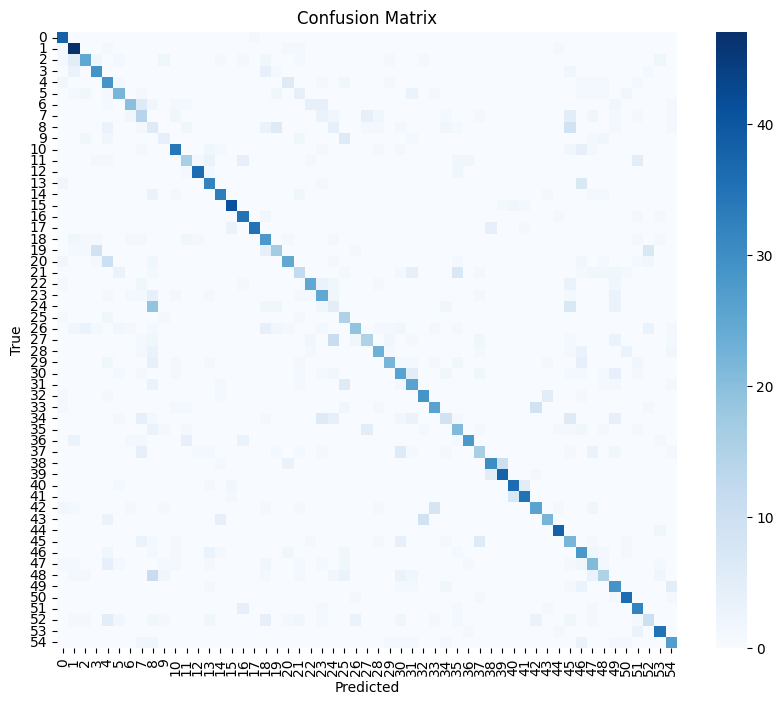

In [6]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Evaluation
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

from sklearn.metrics import classification_report, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# === Accuracies ===
print("Validation Accuracy:", accuracy_score(y_val_split, y_val_pred))
print("Test Accuracy:", accuracy_score(testing_labels, y_test_pred))

# === Average F1 Score (Macro) ===
f1_macro_val = f1_score(y_val_split, y_val_pred, average='macro')
print("Average F1-Score (Macro) on validationdata:", f1_macro_val)
f1_macro_test = f1_score(testing_labels, y_test_pred, average='macro')
print("Average F1-Score (Macro) on testdata:", f1_macro_test)

# === F1 Score for each class ===
print("F1-Score pro Klasse (Testset):\n", f1_score(testing_labels, y_test_pred, average=None))

# === Confusion Matrix ===
cm = confusion_matrix(testing_labels, y_test_pred)

# === Set classes (0 to 54) ===
class_names = [str(i) for i in range(55)]

# === Heatmap Confusion Matrix ===
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=True)

# === Axis labels and title ===
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()